<a href="https://colab.research.google.com/github/aymenchibouti/doctorat/blob/main/complete_model_cnn_res.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== Data Transformation for Model 2 ===
Loading data files...
Enrollment data shape: (120542, 3)
Enrollment columns: ['enrollment_id', 'username', 'course_id']
Sample enrollment data:
   enrollment_id                          username  \
0              1  9Uee7oEuuMmgPx2IzPfFkWgkHZyPbWr0   
1              3  1qXC7Fjbwp66GPQc6pHLfEuO8WKozxG4   
2              4  FIHlppZyoq8muPbdVxS44gfvceX9zvU7   
3              5  p1Mp7WkVfzUijX0peVQKSHbgd5pXyl4c   
4              6  dpK33RH9yepUAnyoywRwBt1AJzxGlaja   

                          course_id  
0  DPnLzkJJqOOPRJfBxIHbQEERiYHu5ila  
1  7GRhBDsirIGkRZBtSMEzNTyDr2JQm4xx  
2  DPnLzkJJqOOPRJfBxIHbQEERiYHu5ila  
3  7GRhBDsirIGkRZBtSMEzNTyDr2JQm4xx  
4  AXUJZGmZ0xaYSWazu8RQ1G5c76ECT1Kd  

Log data shape: (8157277, 5)
Log columns: ['enrollment_id', 'time', 'source', 'event', 'object']
Sample log data:
   enrollment_id                time   source     event  \
0              1 2014-06-14 09:38:29   server  navigate   
1              1 2014-06-14 09

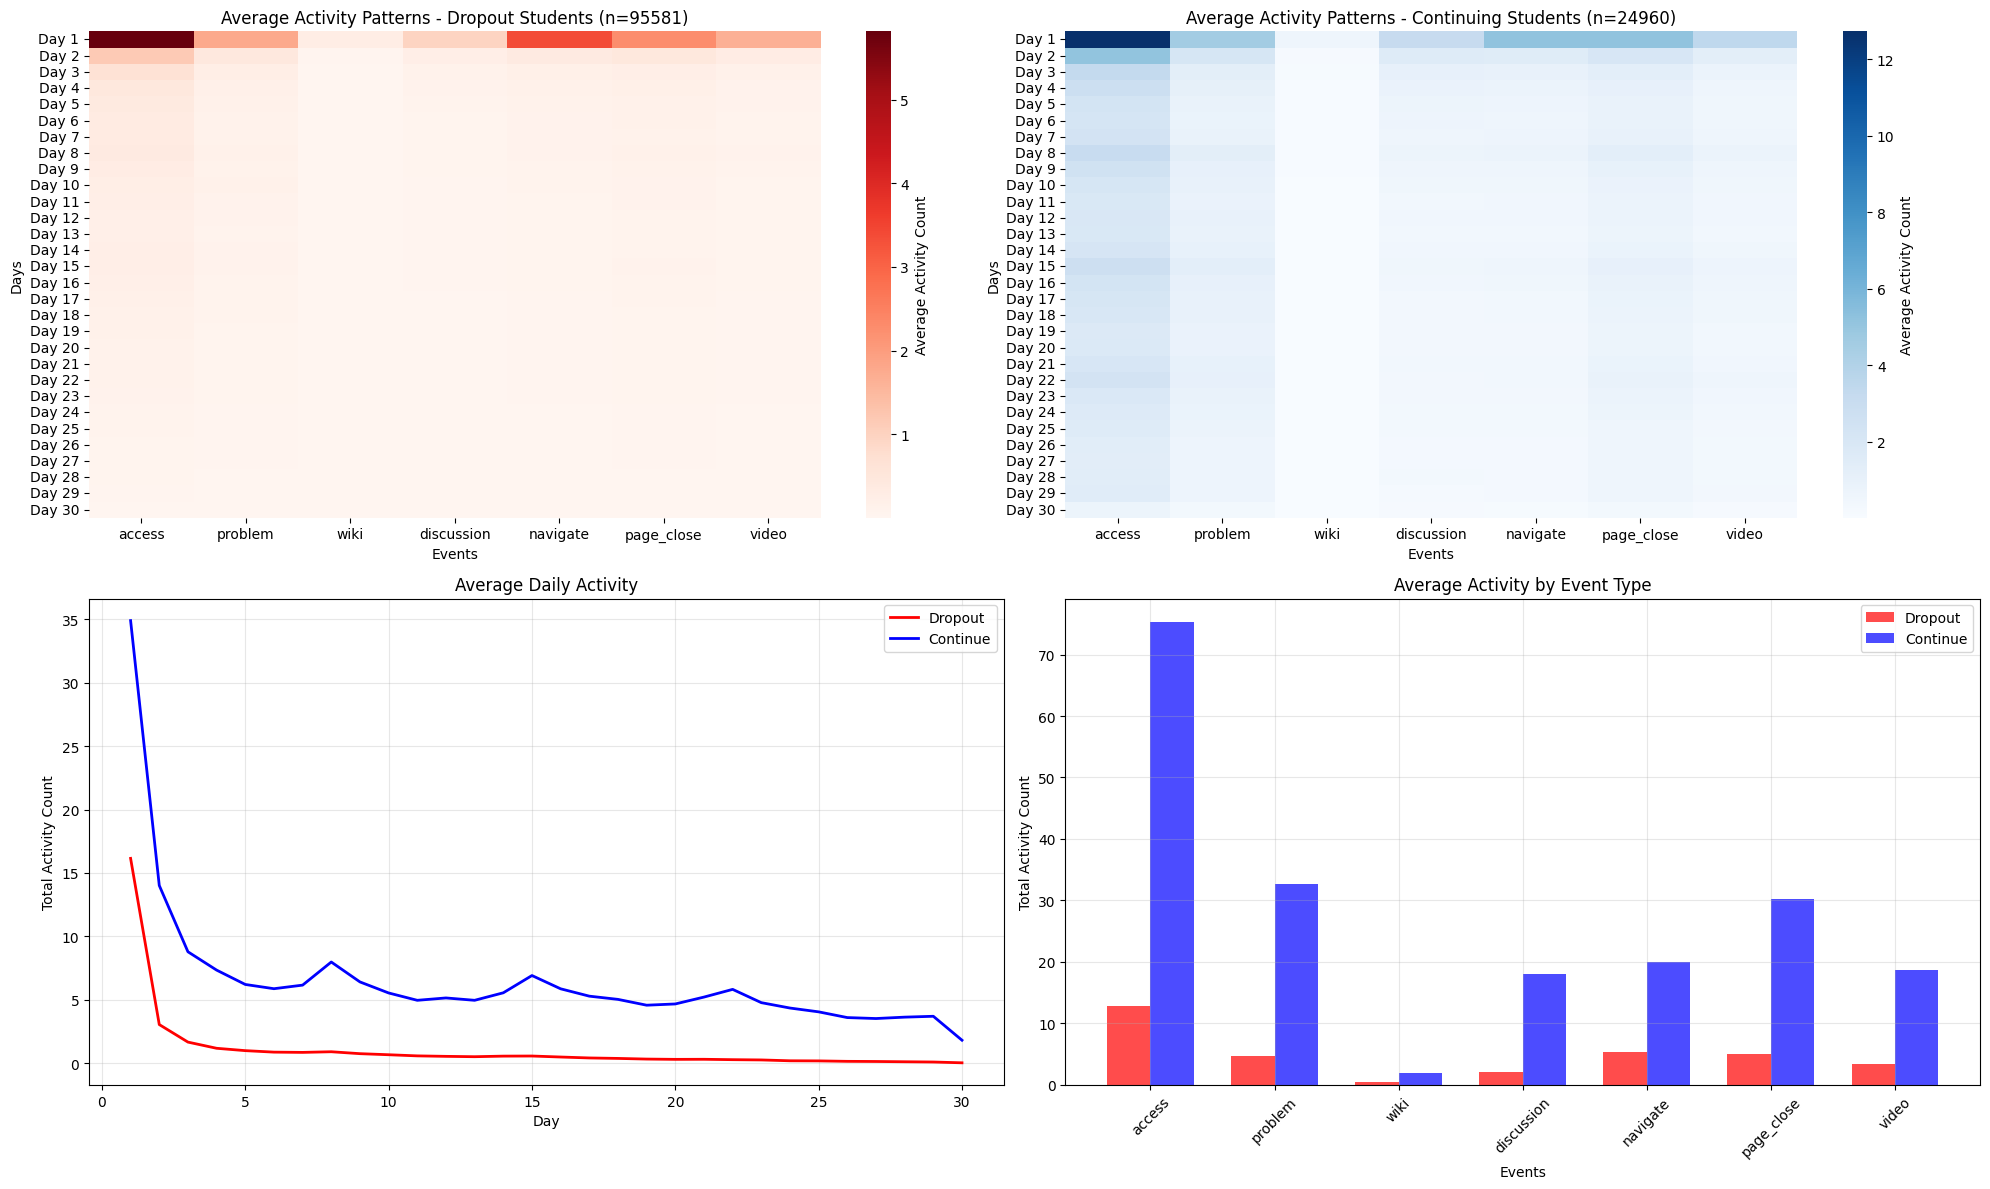


Summary Statistics:
Dropout students:
  Average total activity: 33.92
  Std deviation: 67.84

Continuing students:
  Average total activity: 196.92
  Std deviation: 240.77

Saving processed data...


TypeError: keys must be str, int, float, bool or None, not int64

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_examine_data():
    """
    Load the CSV files and examine their structure
    """
    print("Loading data files...")

    # Load enrollment data
    enrollment_df = pd.read_csv('enrollment_train.csv')
    print("Enrollment data shape:", enrollment_df.shape)
    print("Enrollment columns:", enrollment_df.columns.tolist())
    print("Sample enrollment data:")
    print(enrollment_df.head())

    # Load log data
    log_df = pd.read_csv('log_train.csv')
    log_df['time'] = pd.to_datetime(log_df['time'])
    print("\nLog data shape:", log_df.shape)
    print("Log columns:", log_df.columns.tolist())
    print("Sample log data:")
    print(log_df.head())
    print("Unique events:", sorted(log_df['event'].unique()))

    # Load truth data
    truth_df = pd.read_csv('truth_train.csv')
    # The columns seem to be labeled as '1' and '0', let's examine them
    print("\nTruth data shape:", truth_df.shape)
    print("Truth columns:", truth_df.columns.tolist())
    print("Sample truth data:")
    print(truth_df.head(10))

    # Analyze the truth data structure
    print("\nAnalyzing truth data structure:")
    print("Column '0' unique values:", sorted(truth_df['0'].unique()))
    print("Column '1' value range:", truth_df['1'].min(), "to", truth_df['1'].max())

    # It appears column '1' contains enrollment_ids and column '0' contains labels
    # Let's verify this
    enrollment_ids_set = set(enrollment_df['enrollment_id'])
    truth_col1_set = set(truth_df['1'])

    print(f"\nEnrollment IDs in enrollment file: {len(enrollment_ids_set)}")
    print(f"Values in truth column '1': {len(truth_col1_set)}")
    print(f"Overlap: {len(enrollment_ids_set.intersection(truth_col1_set))}")

    # Rename truth columns properly
    truth_df = truth_df.rename(columns={'1': 'enrollment_id', '0': 'dropout'})

    return enrollment_df, log_df, truth_df

def create_model2_matrices(log_df, truth_df, enrollment_df):
    """
    Create Model 2 structure: 30-day x 7-event matrices for each student
    """
    print("\nCreating Model 2 matrices...")

    # Define the 7 events from the document
    events = ['access', 'problem', 'wiki', 'discussion', 'navigate', 'page_close', 'video']
    event_to_idx = {event: idx for idx, event in enumerate(events)}

    # Get students who have both logs and labels
    logged_students = set(log_df['enrollment_id'].unique())
    labeled_students = set(truth_df['enrollment_id'].unique())
    enrolled_students = set(enrollment_df['enrollment_id'].unique())

    valid_students = logged_students.intersection(labeled_students).intersection(enrolled_students)
    print(f"Students with logs, labels, and enrollment: {len(valid_students)}")

    # Initialize arrays
    matrices = []
    labels = []
    student_ids = []

    # Group logs by student
    log_grouped = log_df.groupby('enrollment_id')

    # Process each valid student
    for student_id in valid_students:
        if student_id in log_grouped.groups:
            # Get student's logs
            student_logs = log_grouped.get_group(student_id)

            # Find the earliest activity date for this student
            start_date = student_logs['time'].min().date()

            # Create 30 x 7 matrix
            matrix = np.zeros((30, 7))

            # Fill matrix with activity counts
            for _, row in student_logs.iterrows():
                event_date = row['time'].date()
                days_from_start = (event_date - start_date).days

                # Only consider first 30 days
                if 0 <= days_from_start < 30:
                    event_name = row['event']
                    if event_name in event_to_idx:
                        day_idx = days_from_start
                        event_idx = event_to_idx[event_name]
                        matrix[day_idx, event_idx] += 1

            # Get label
            label = truth_df[truth_df['enrollment_id'] == student_id]['dropout'].iloc[0]

            matrices.append(matrix)
            labels.append(label)
            student_ids.append(student_id)

    # Convert to numpy arrays
    X = np.array(matrices)
    y = np.array(labels)

    print(f"\nCreated matrices for {len(X)} students")
    print(f"Matrix shape per student: {X[0].shape}")
    print(f"Total data shape: {X.shape}")
    print(f"Labels distribution:")
    unique, counts = np.unique(y, return_counts=True)
    for label, count in zip(unique, counts):
        print(f"  Label {label}: {count} students ({count/len(y)*100:.1f}%)")

    return X, y, student_ids, events

def visualize_data_patterns(X, y, events):
    """
    Visualize patterns in the Model 2 data
    """
    print("\nVisualizing data patterns...")

    # Separate by dropout status
    dropout_matrices = X[y == 1]
    continue_matrices = X[y == 0]

    if len(dropout_matrices) == 0 or len(continue_matrices) == 0:
        print("Warning: No samples found for one of the classes")
        return

    # Calculate averages
    dropout_avg = np.mean(dropout_matrices, axis=0)
    continue_avg = np.mean(continue_matrices, axis=0)

    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))

    # Heatmap for dropout students
    sns.heatmap(dropout_avg,
                xticklabels=events,
                yticklabels=[f'Day {i+1}' for i in range(30)],
                ax=axes[0,0],
                cmap='Reds',
                cbar_kws={'label': 'Average Activity Count'})
    axes[0,0].set_title(f'Average Activity Patterns - Dropout Students (n={len(dropout_matrices)})')
    axes[0,0].set_xlabel('Events')
    axes[0,0].set_ylabel('Days')

    # Heatmap for continuing students
    sns.heatmap(continue_avg,
                xticklabels=events,
                yticklabels=[f'Day {i+1}' for i in range(30)],
                ax=axes[0,1],
                cmap='Blues',
                cbar_kws={'label': 'Average Activity Count'})
    axes[0,1].set_title(f'Average Activity Patterns - Continuing Students (n={len(continue_matrices)})')
    axes[0,1].set_xlabel('Events')
    axes[0,1].set_ylabel('Days')

    # Daily activity totals
    dropout_daily = np.sum(dropout_avg, axis=1)
    continue_daily = np.sum(continue_avg, axis=1)

    axes[1,0].plot(range(1, 31), dropout_daily, 'r-', label='Dropout', linewidth=2)
    axes[1,0].plot(range(1, 31), continue_daily, 'b-', label='Continue', linewidth=2)
    axes[1,0].set_title('Average Daily Activity')
    axes[1,0].set_xlabel('Day')
    axes[1,0].set_ylabel('Total Activity Count')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # Event totals
    dropout_events = np.sum(dropout_avg, axis=0)
    continue_events = np.sum(continue_avg, axis=0)

    x_pos = np.arange(len(events))
    width = 0.35

    axes[1,1].bar(x_pos - width/2, dropout_events, width, label='Dropout', color='red', alpha=0.7)
    axes[1,1].bar(x_pos + width/2, continue_events, width, label='Continue', color='blue', alpha=0.7)
    axes[1,1].set_title('Average Activity by Event Type')
    axes[1,1].set_xlabel('Events')
    axes[1,1].set_ylabel('Total Activity Count')
    axes[1,1].set_xticks(x_pos)
    axes[1,1].set_xticklabels(events, rotation=45)
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(f"\nSummary Statistics:")
    print(f"Dropout students:")
    print(f"  Average total activity: {np.mean(np.sum(dropout_matrices, axis=(1,2))):.2f}")
    print(f"  Std deviation: {np.std(np.sum(dropout_matrices, axis=(1,2))):.2f}")

    print(f"\nContinuing students:")
    print(f"  Average total activity: {np.mean(np.sum(continue_matrices, axis=(1,2))):.2f}")
    print(f"  Std deviation: {np.std(np.sum(continue_matrices, axis=(1,2))):.2f}")

def save_processed_data(X, y, student_ids, events):
    """
    Save the processed data for later use
    """
    print("\nSaving processed data...")

    # Save as numpy arrays
    np.save('model2_X.npy', X)
    np.save('model2_y.npy', y)
    np.save('model2_student_ids.npy', student_ids)

    # Save metadata
    metadata = {
        'n_students': len(X),
        'n_days': 30,
        'n_events': 7,
        'events': events,
        'data_shape': X.shape,
        'label_distribution': dict(zip(*np.unique(y, return_counts=True)))
    }

    import json
    with open('model2_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)

    print("Data saved successfully!")
    print("Files created:")
    print("  - model2_X.npy: Student matrices")
    print("  - model2_y.npy: Labels")
    print("  - model2_student_ids.npy: Student IDs")
    print("  - model2_metadata.json: Dataset metadata")

def main():
    """
    Main function to transform data to Model 2 format
    """
    print("=== Data Transformation for Model 2 ===")

    # Load and examine data
    enrollment_df, log_df, truth_df = load_and_examine_data()

    # Create Model 2 matrices
    X, y, student_ids, events = create_model2_matrices(log_df, truth_df, enrollment_df)

    # Visualize patterns
    visualize_data_patterns(X, y, events)

    # Save processed data
    save_processed_data(X, y, student_ids, events)

    return X, y, student_ids, events

if __name__ == "__main__":
    X, y, student_ids, events = main()


=== Data Transformation for Model 2 ===
Loading data files...
Enrollment data shape: (120542, 3)
Enrollment columns: ['enrollment_id', 'username', 'course_id']
Sample enrollment data:
   enrollment_id                          username  \
0              1  9Uee7oEuuMmgPx2IzPfFkWgkHZyPbWr0   
1              3  1qXC7Fjbwp66GPQc6pHLfEuO8WKozxG4   
2              4  FIHlppZyoq8muPbdVxS44gfvceX9zvU7   
3              5  p1Mp7WkVfzUijX0peVQKSHbgd5pXyl4c   
4              6  dpK33RH9yepUAnyoywRwBt1AJzxGlaja   

                          course_id  
0  DPnLzkJJqOOPRJfBxIHbQEERiYHu5ila  
1  7GRhBDsirIGkRZBtSMEzNTyDr2JQm4xx  
2  DPnLzkJJqOOPRJfBxIHbQEERiYHu5ila  
3  7GRhBDsirIGkRZBtSMEzNTyDr2JQm4xx  
4  AXUJZGmZ0xaYSWazu8RQ1G5c76ECT1Kd  

Log data shape: (8157277, 5)
Log columns: ['enrollment_id', 'time', 'source', 'event', 'object']
Sample log data:
   enrollment_id                time   source     event  \
0              1 2014-06-14 09:38:29   server  navigate   
1              1 2014-06-14 09

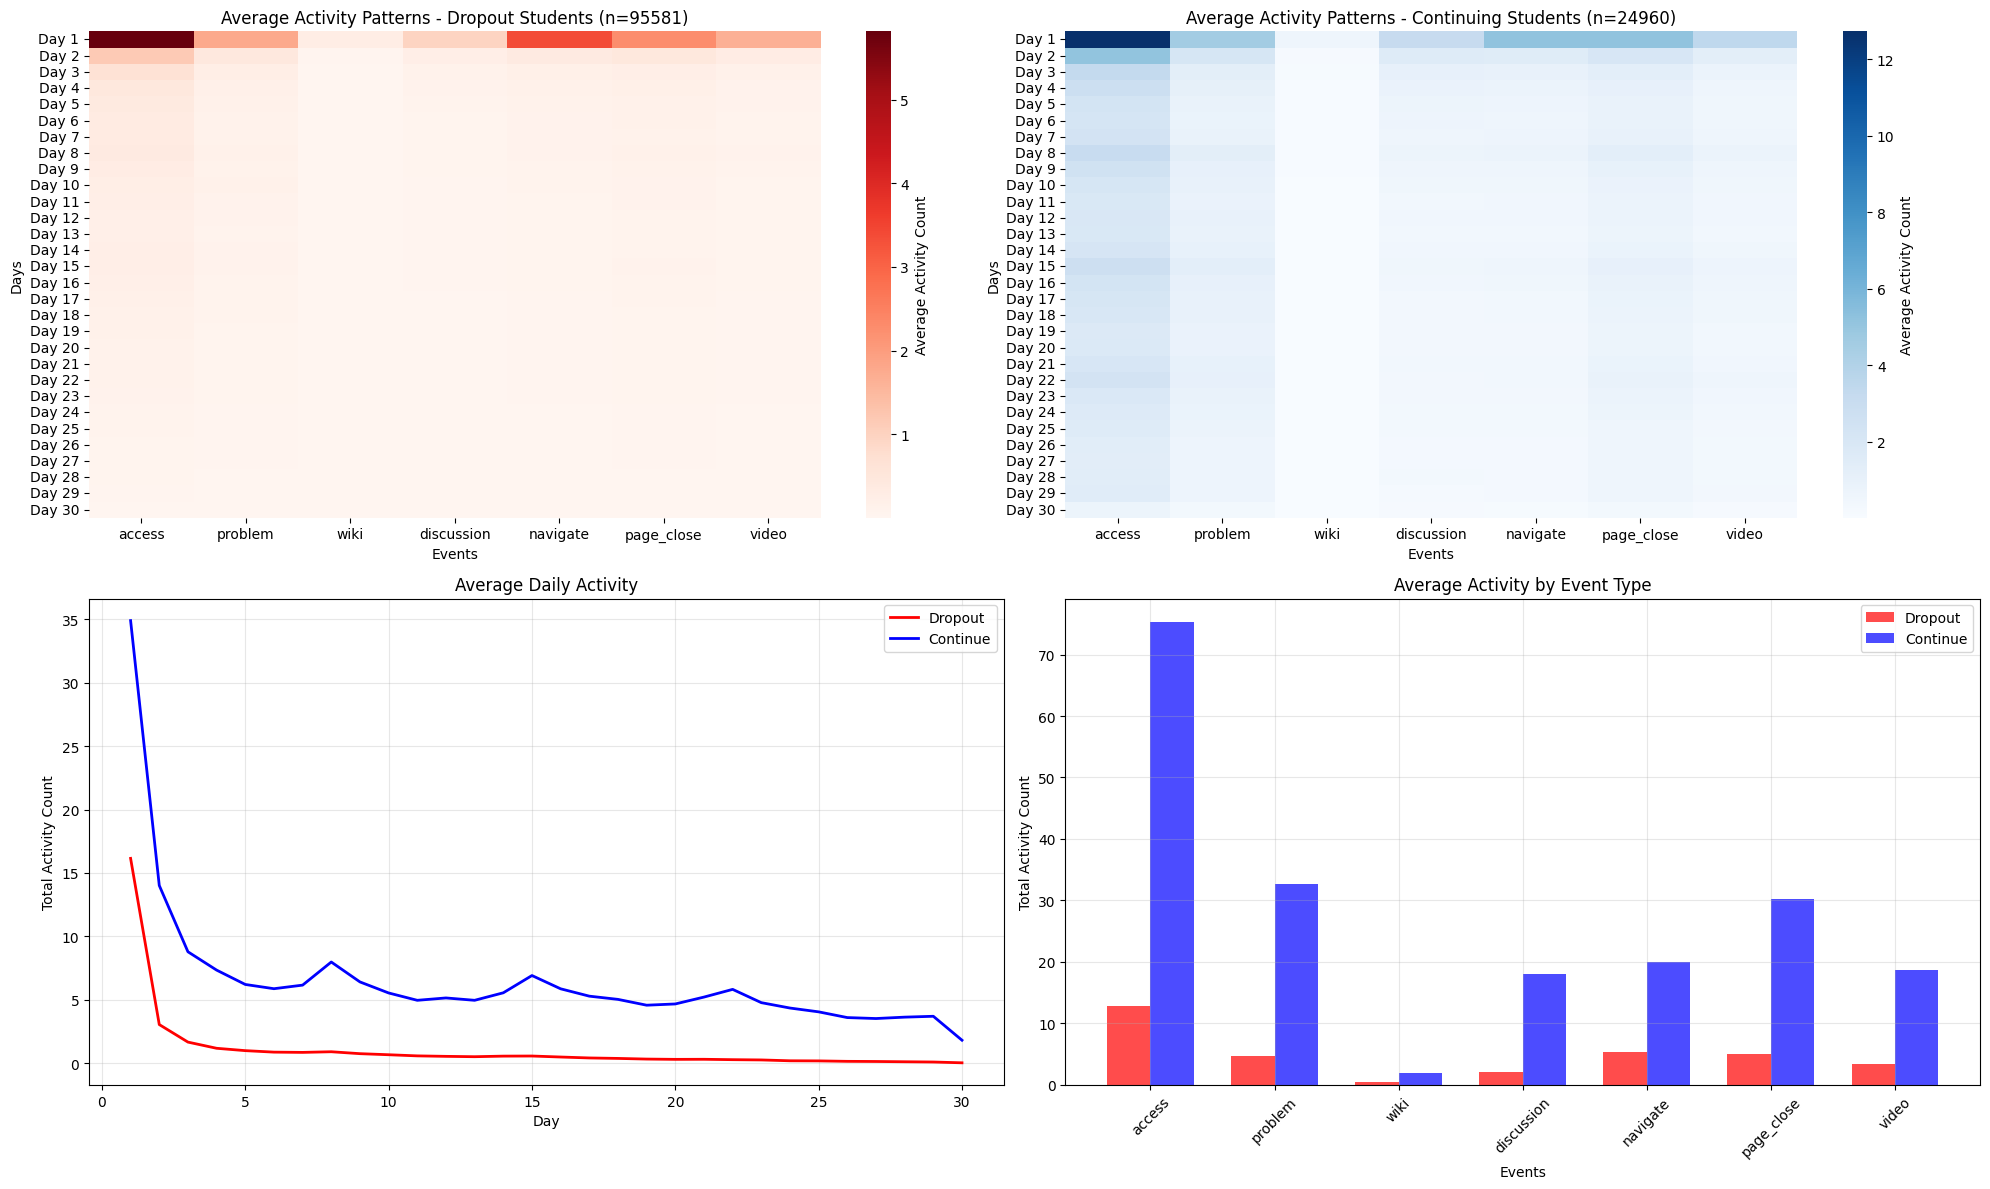


Summary Statistics:
Dropout students:
  Average total activity: 33.92
  Std deviation: 67.84

Continuing students:
  Average total activity: 196.92
  Std deviation: 240.77

Saving processed data...
Data saved successfully!
Files created:
  - model2_X.npy: Student matrices
  - model2_y.npy: Labels
  - model2_student_ids.npy: Student IDs
  - model2_metadata.json: Dataset metadata


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_examine_data():
    """
    Load the CSV files and examine their structure
    """
    print("Loading data files...")

    # Load enrollment data
    enrollment_df = pd.read_csv('enrollment_train.csv')
    print("Enrollment data shape:", enrollment_df.shape)
    print("Enrollment columns:", enrollment_df.columns.tolist())
    print("Sample enrollment data:")
    print(enrollment_df.head())

    # Load log data
    log_df = pd.read_csv('log_train.csv')
    log_df['time'] = pd.to_datetime(log_df['time'])
    print("\nLog data shape:", log_df.shape)
    print("Log columns:", log_df.columns.tolist())
    print("Sample log data:")
    print(log_df.head())
    print("Unique events:", sorted(log_df['event'].unique()))

    # Load truth data
    truth_df = pd.read_csv('truth_train.csv')
    # The columns seem to be labeled as '1' and '0', let's examine them
    print("\nTruth data shape:", truth_df.shape)
    print("Truth columns:", truth_df.columns.tolist())
    print("Sample truth data:")
    print(truth_df.head(10))

    # Analyze the truth data structure
    print("\nAnalyzing truth data structure:")
    print("Column '0' unique values:", sorted(truth_df['0'].unique()))
    print("Column '1' value range:", truth_df['1'].min(), "to", truth_df['1'].max())

    # It appears column '1' contains enrollment_ids and column '0' contains labels
    # Let's verify this
    enrollment_ids_set = set(enrollment_df['enrollment_id'])
    truth_col1_set = set(truth_df['1'])

    print(f"\nEnrollment IDs in enrollment file: {len(enrollment_ids_set)}")
    print(f"Values in truth column '1': {len(truth_col1_set)}")
    print(f"Overlap: {len(enrollment_ids_set.intersection(truth_col1_set))}")

    # Rename truth columns properly
    truth_df = truth_df.rename(columns={'1': 'enrollment_id', '0': 'dropout'})

    return enrollment_df, log_df, truth_df

def create_model2_matrices(log_df, truth_df, enrollment_df):
    """
    Create Model 2 structure: 30-day x 7-event matrices for each student
    """
    print("\nCreating Model 2 matrices...")

    # Define the 7 events from the document
    events = ['access', 'problem', 'wiki', 'discussion', 'navigate', 'page_close', 'video']
    event_to_idx = {event: idx for idx, event in enumerate(events)}

    # Get students who have both logs and labels
    logged_students = set(log_df['enrollment_id'].unique())
    labeled_students = set(truth_df['enrollment_id'].unique())
    enrolled_students = set(enrollment_df['enrollment_id'].unique())

    valid_students = logged_students.intersection(labeled_students).intersection(enrolled_students)
    print(f"Students with logs, labels, and enrollment: {len(valid_students)}")

    # Initialize arrays
    matrices = []
    labels = []
    student_ids = []

    # Group logs by student
    log_grouped = log_df.groupby('enrollment_id')

    # Process each valid student
    for student_id in valid_students:
        if student_id in log_grouped.groups:
            # Get student's logs
            student_logs = log_grouped.get_group(student_id)

            # Find the earliest activity date for this student
            start_date = student_logs['time'].min().date()

            # Create 30 x 7 matrix
            matrix = np.zeros((30, 7))

            # Fill matrix with activity counts
            for _, row in student_logs.iterrows():
                event_date = row['time'].date()
                days_from_start = (event_date - start_date).days

                # Only consider first 30 days
                if 0 <= days_from_start < 30:
                    event_name = row['event']
                    if event_name in event_to_idx:
                        day_idx = days_from_start
                        event_idx = event_to_idx[event_name]
                        matrix[day_idx, event_idx] += 1

            # Get label
            label = truth_df[truth_df['enrollment_id'] == student_id]['dropout'].iloc[0]

            matrices.append(matrix)
            labels.append(label)
            student_ids.append(student_id)

    # Convert to numpy arrays
    X = np.array(matrices)
    y = np.array(labels)

    print(f"\nCreated matrices for {len(X)} students")
    print(f"Matrix shape per student: {X[0].shape}")
    print(f"Total data shape: {X.shape}")
    print(f"Labels distribution:")
    unique, counts = np.unique(y, return_counts=True)
    for label, count in zip(unique, counts):
        print(f"  Label {label}: {count} students ({count/len(y)*100:.1f}%)")

    return X, y, student_ids, events

def visualize_data_patterns(X, y, events):
    """
    Visualize patterns in the Model 2 data
    """
    print("\nVisualizing data patterns...")

    # Separate by dropout status
    dropout_matrices = X[y == 1]
    continue_matrices = X[y == 0]

    if len(dropout_matrices) == 0 or len(continue_matrices) == 0:
        print("Warning: No samples found for one of the classes")
        return

    # Calculate averages
    dropout_avg = np.mean(dropout_matrices, axis=0)
    continue_avg = np.mean(continue_matrices, axis=0)

    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))

    # Heatmap for dropout students
    sns.heatmap(dropout_avg,
                xticklabels=events,
                yticklabels=[f'Day {i+1}' for i in range(30)],
                ax=axes[0,0],
                cmap='Reds',
                cbar_kws={'label': 'Average Activity Count'})
    axes[0,0].set_title(f'Average Activity Patterns - Dropout Students (n={len(dropout_matrices)})')
    axes[0,0].set_xlabel('Events')
    axes[0,0].set_ylabel('Days')

    # Heatmap for continuing students
    sns.heatmap(continue_avg,
                xticklabels=events,
                yticklabels=[f'Day {i+1}' for i in range(30)],
                ax=axes[0,1],
                cmap='Blues',
                cbar_kws={'label': 'Average Activity Count'})
    axes[0,1].set_title(f'Average Activity Patterns - Continuing Students (n={len(continue_matrices)})')
    axes[0,1].set_xlabel('Events')
    axes[0,1].set_ylabel('Days')

    # Daily activity totals
    dropout_daily = np.sum(dropout_avg, axis=1)
    continue_daily = np.sum(continue_avg, axis=1)

    axes[1,0].plot(range(1, 31), dropout_daily, 'r-', label='Dropout', linewidth=2)
    axes[1,0].plot(range(1, 31), continue_daily, 'b-', label='Continue', linewidth=2)
    axes[1,0].set_title('Average Daily Activity')
    axes[1,0].set_xlabel('Day')
    axes[1,0].set_ylabel('Total Activity Count')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # Event totals
    dropout_events = np.sum(dropout_avg, axis=0)
    continue_events = np.sum(continue_avg, axis=0)

    x_pos = np.arange(len(events))
    width = 0.35

    axes[1,1].bar(x_pos - width/2, dropout_events, width, label='Dropout', color='red', alpha=0.7)
    axes[1,1].bar(x_pos + width/2, continue_events, width, label='Continue', color='blue', alpha=0.7)
    axes[1,1].set_title('Average Activity by Event Type')
    axes[1,1].set_xlabel('Events')
    axes[1,1].set_ylabel('Total Activity Count')
    axes[1,1].set_xticks(x_pos)
    axes[1,1].set_xticklabels(events, rotation=45)
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(f"\nSummary Statistics:")
    print(f"Dropout students:")
    print(f"  Average total activity: {np.mean(np.sum(dropout_matrices, axis=(1,2))):.2f}")
    print(f"  Std deviation: {np.std(np.sum(dropout_matrices, axis=(1,2))):.2f}")

    print(f"\nContinuing students:")
    print(f"  Average total activity: {np.mean(np.sum(continue_matrices, axis=(1,2))):.2f}")
    print(f"  Std deviation: {np.std(np.sum(continue_matrices, axis=(1,2))):.2f}")

def save_processed_data(X, y, student_ids, events):
    """
    Save the processed data for later use
    """
    print("\nSaving processed data...")

    # Save as numpy arrays
    np.save('model2_X.npy', X)
    np.save('model2_y.npy', y)
    np.save('model2_student_ids.npy', student_ids)

    # Save metadata - convert numpy types to native Python types for JSON compatibility
    unique_labels, label_counts = np.unique(y, return_counts=True)
    label_distribution = {int(label): int(count) for label, count in zip(unique_labels, label_counts)}

    metadata = {
        'n_students': int(len(X)),
        'n_days': 30,
        'n_events': 7,
        'events': events,
        'data_shape': [int(dim) for dim in X.shape],  # Convert to list of ints
        'label_distribution': label_distribution
    }

    import json
    with open('model2_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)

    print("Data saved successfully!")
    print("Files created:")
    print("  - model2_X.npy: Student matrices")
    print("  - model2_y.npy: Labels")
    print("  - model2_student_ids.npy: Student IDs")
    print("  - model2_metadata.json: Dataset metadata")

def load_processed_data():
    """
    Load previously processed Model 2 data
    """
    try:
        print("Loading processed Model 2 data...")

        X = np.load('model2_X.npy')
        y = np.load('model2_y.npy')
        student_ids = np.load('model2_student_ids.npy')

        import json
        with open('model2_metadata.json', 'r') as f:
            metadata = json.load(f)

        events = metadata['events']

        print(f"Loaded data for {len(X)} students")
        print(f"Matrix shape: {X.shape}")
        print(f"Events: {events}")
        print(f"Label distribution: {metadata['label_distribution']}")

        return X, y, student_ids, events, metadata

    except FileNotFoundError:
        print("Processed data files not found. Please run the main() function first to process the raw data.")
        return None, None, None, None, None

def main():
    """
    Main function to transform data to Model 2 format
    """
    print("=== Data Transformation for Model 2 ===")

    # Load and examine data
    enrollment_df, log_df, truth_df = load_and_examine_data()

    # Create Model 2 matrices
    X, y, student_ids, events = create_model2_matrices(log_df, truth_df, enrollment_df)

    # Visualize patterns
    visualize_data_patterns(X, y, events)

    # Save processed data
    save_processed_data(X, y, student_ids, events)

    return X, y, student_ids, events

if __name__ == "__main__":
    X, y, student_ids, events = main()


=== Student Dropout Prediction with CNN (Model 2) ===
Loading processed Model 2 data...
Loaded data for 120541 students
Matrix shape: (120541, 30, 7)
Label distribution: {'0': 24960, '1': 95581}
Working with 120541 students
Dropout rate: 79.3%

Model built successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 30, 7, 32)      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 30, 7, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 30, 7, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 15, 3, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 15, 3, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 15, 3, 64)      │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 15, 3, 64)      │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 15, 3, 64)      │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 7, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 7, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 7, 1, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 7, 1, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 7, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_pool                     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_dense1 (BatchNormalization)  │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense1 (Dropout)        │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_dense2 (BatchNormalization)  │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense2 (Dropout)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense3 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense3 (Dropout)        │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,129 (609.88 KB)

 Trainable params: 154,913 (605.13 KB)

 Non-trainable params: 1,216 (4.75 KB)

Training set: 96432 samples
Test set: 24109 samples
Input shape: (30, 7, 1)
Class distribution - Training:
  Class 0: 19968 (20.7%)
  Class 1: 76464 (79.3%)
Class weights: {np.int64(0): np.float64(2.4146634615384617), np.int64(1): np.float64(0.630571249215317)}

TRAINING PHASE
Starting training...
Epoch 1/50
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7742 - loss: 0.5631 - precision: 0.9124 - recall: 0.7920
Epoch 1: val_loss improved from inf to 0.43170, saving model to best_dropout_model.h5


2411/2411 ━━━━━━━━━━━━━━━━━━━━ 108s 42ms/step - accuracy: 0.7742 - loss: 0.5631 - precision: 0.9124 - recall: 0.7920 - val_accuracy: 0.8180 - val_loss: 0.4317 - val_precision: 0.9230 - val_recall: 0.8415 - learning_rate: 0.0010
Epoch 2/50
2410/2411 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8019 - loss: 0.4895 - precision: 0.9241 - recall: 0.8173
Epoch 2: val_loss did not improve from 0.43170
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 95s 39ms/step - accuracy: 0.8019 - loss: 0.4895 - precision: 0.9241 - recall: 0.8173 - val_accuracy: 0.8197 - val_loss: 0.4669 - val_precision: 0.9235 - val_recall: 0.8432 - learning_rate: 0.0010
Epoch 3/50
2410/2411 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8023 - loss: 0.4884 - precision: 0.9233 - recall: 0.8183
Epoch 3: val_loss did not improve from 0.43170
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 141s 39ms/step - accuracy: 0.8023 - loss: 0.4884 - precision: 0.9233 - recall: 0.8183 - val_accuracy: 0.2042 - val_loss: 0.9817 - val_precision: 0.0000e+00 - val_recall

2411/2411 ━━━━━━━━━━━━━━━━━━━━ 97s 40ms/step - accuracy: 0.8075 - loss: 0.4814 - precision: 0.9246 - recall: 0.8244 - val_accuracy: 0.8362 - val_loss: 0.4223 - val_precision: 0.9183 - val_recall: 0.8717 - learning_rate: 0.0010
Epoch 5/50
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8098 - loss: 0.4803 - precision: 0.9217 - recall: 0.8301
Epoch 5: val_loss did not improve from 0.42234
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 141s 40ms/step - accuracy: 0.8098 - loss: 0.4803 - precision: 0.9217 - recall: 0.8301 - val_accuracy: 0.8138 - val_loss: 0.4634 - val_precision: 0.9258 - val_recall: 0.8328 - learning_rate: 0.0010
Epoch 6/50
2410/2411 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8187 - loss: 0.4755 - precision: 0.9226 - recall: 0.8422
Epoch 6: val_loss did not improve from 0.42234
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 96s 40ms/step - accuracy: 0.8187 - loss: 0.4755 - precision: 0.9226 - recall: 0.8422 - val_accuracy: 0.7448 - val_loss: 0.5956 - val_precision: 0.9377 - val_recall: 0.7

2411/2411 ━━━━━━━━━━━━━━━━━━━━ 136s 40ms/step - accuracy: 0.8177 - loss: 0.4770 - precision: 0.9205 - recall: 0.8420 - val_accuracy: 0.8331 - val_loss: 0.3982 - val_precision: 0.9184 - val_recall: 0.8673 - learning_rate: 0.0010
Epoch 9/50
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8314 - loss: 0.4652 - precision: 0.9215 - recall: 0.8613
Epoch 9: val_loss did not improve from 0.39821
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 96s 40ms/step - accuracy: 0.8314 - loss: 0.4652 - precision: 0.9214 - recall: 0.8613 - val_accuracy: 0.8232 - val_loss: 0.4257 - val_precision: 0.9235 - val_recall: 0.8481 - learning_rate: 0.0010
Epoch 10/50
2410/2411 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8260 - loss: 0.4693 - precision: 0.9222 - recall: 0.8529
Epoch 10: val_loss did not improve from 0.39821
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 142s 40ms/step - accuracy: 0.8260 - loss: 0.4693 - precision: 0.9222 - recall: 0.8529 - val_accuracy: 0.8135 - val_loss: 0.4504 - val_precision: 0.9272 - val_recall: 

2411/2411 ━━━━━━━━━━━━━━━━━━━━ 95s 40ms/step - accuracy: 0.8213 - loss: 0.4718 - precision: 0.9224 - recall: 0.8447 - val_accuracy: 0.8420 - val_loss: 0.3809 - val_precision: 0.9156 - val_recall: 0.8829 - learning_rate: 0.0010
Epoch 14/50
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8248 - loss: 0.4725 - precision: 0.9207 - recall: 0.8526
Epoch 14: val_loss did not improve from 0.38091
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 140s 39ms/step - accuracy: 0.8248 - loss: 0.4725 - precision: 0.9207 - recall: 0.8526 - val_accuracy: 0.8337 - val_loss: 0.4164 - val_precision: 0.9184 - val_recall: 0.8681 - learning_rate: 0.0010
Epoch 15/50
2410/2411 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8233 - loss: 0.4729 - precision: 0.9201 - recall: 0.8512
Epoch 15: val_loss did not improve from 0.38091
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 146s 40ms/step - accuracy: 0.8233 - loss: 0.4729 - precision: 0.9201 - recall: 0.8512 - val_accuracy: 0.8216 - val_loss: 0.4310 - val_precision: 0.9243 - val_recall

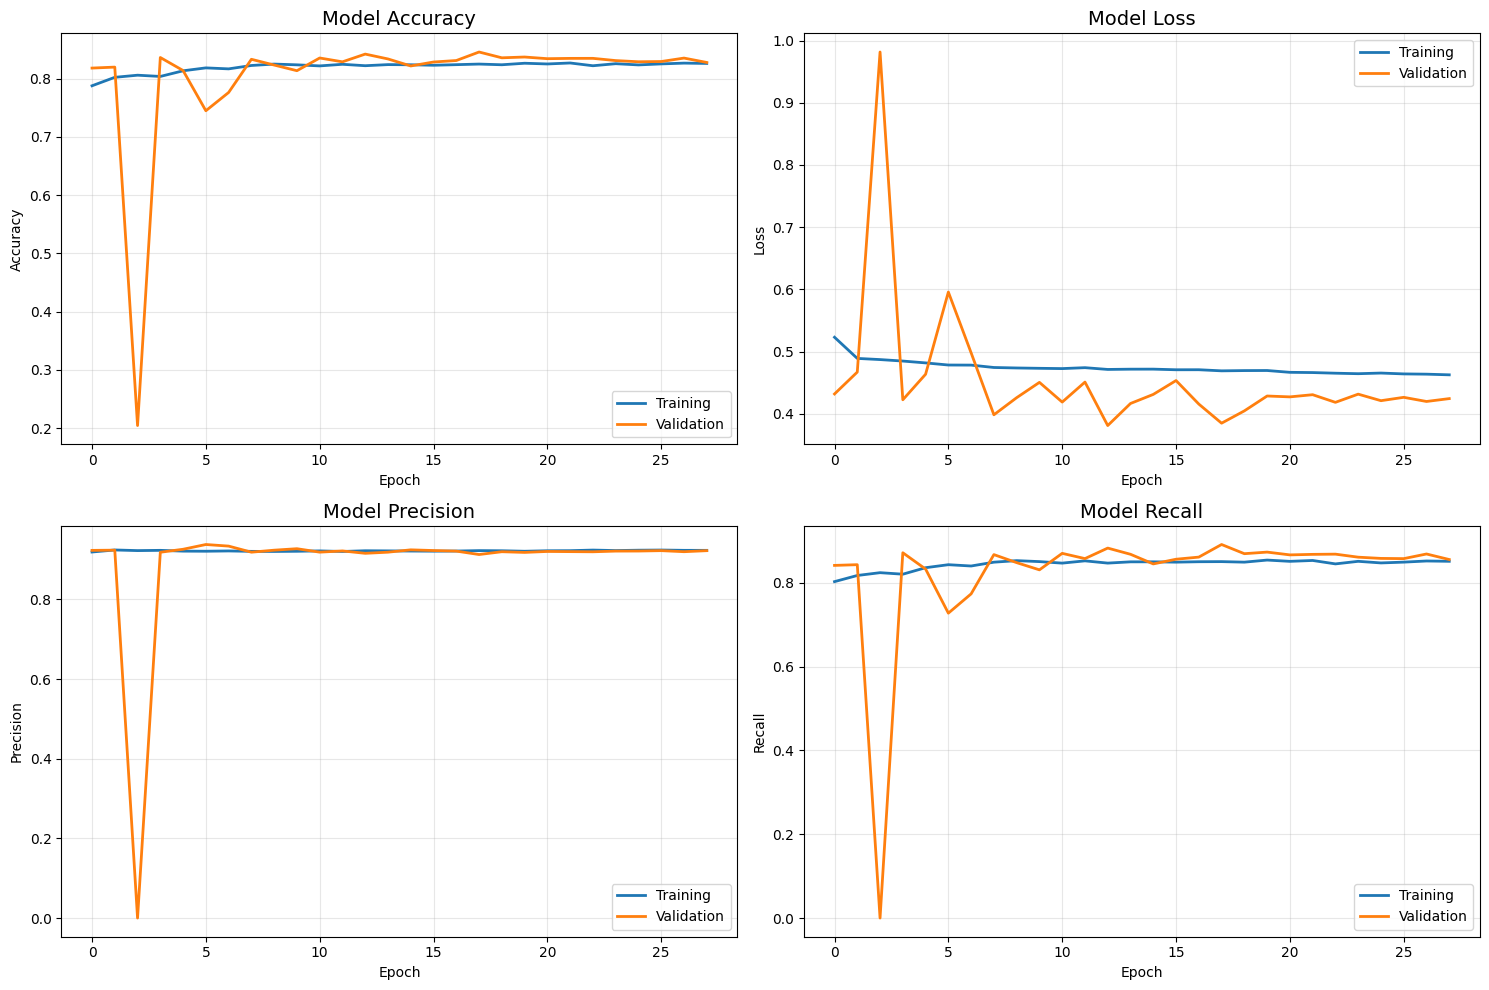


EVALUATION PHASE
754/754 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step
\n=== TEST SET EVALUATION ===
Accuracy: 0.8374
Precision: 0.9138
Recall: 0.8779
F1-Score: 0.8954
AUC-ROC: 0.8553
\n=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

    Continue       0.59      0.68      0.63      4992
     Dropout       0.91      0.88      0.90     19117

    accuracy                           0.84     24109
   macro avg       0.75      0.78      0.77     24109
weighted avg       0.85      0.84      0.84     24109

\n=== CONFUSION MATRIX ===
[[ 3408  1584]
 [ 2335 16782]]


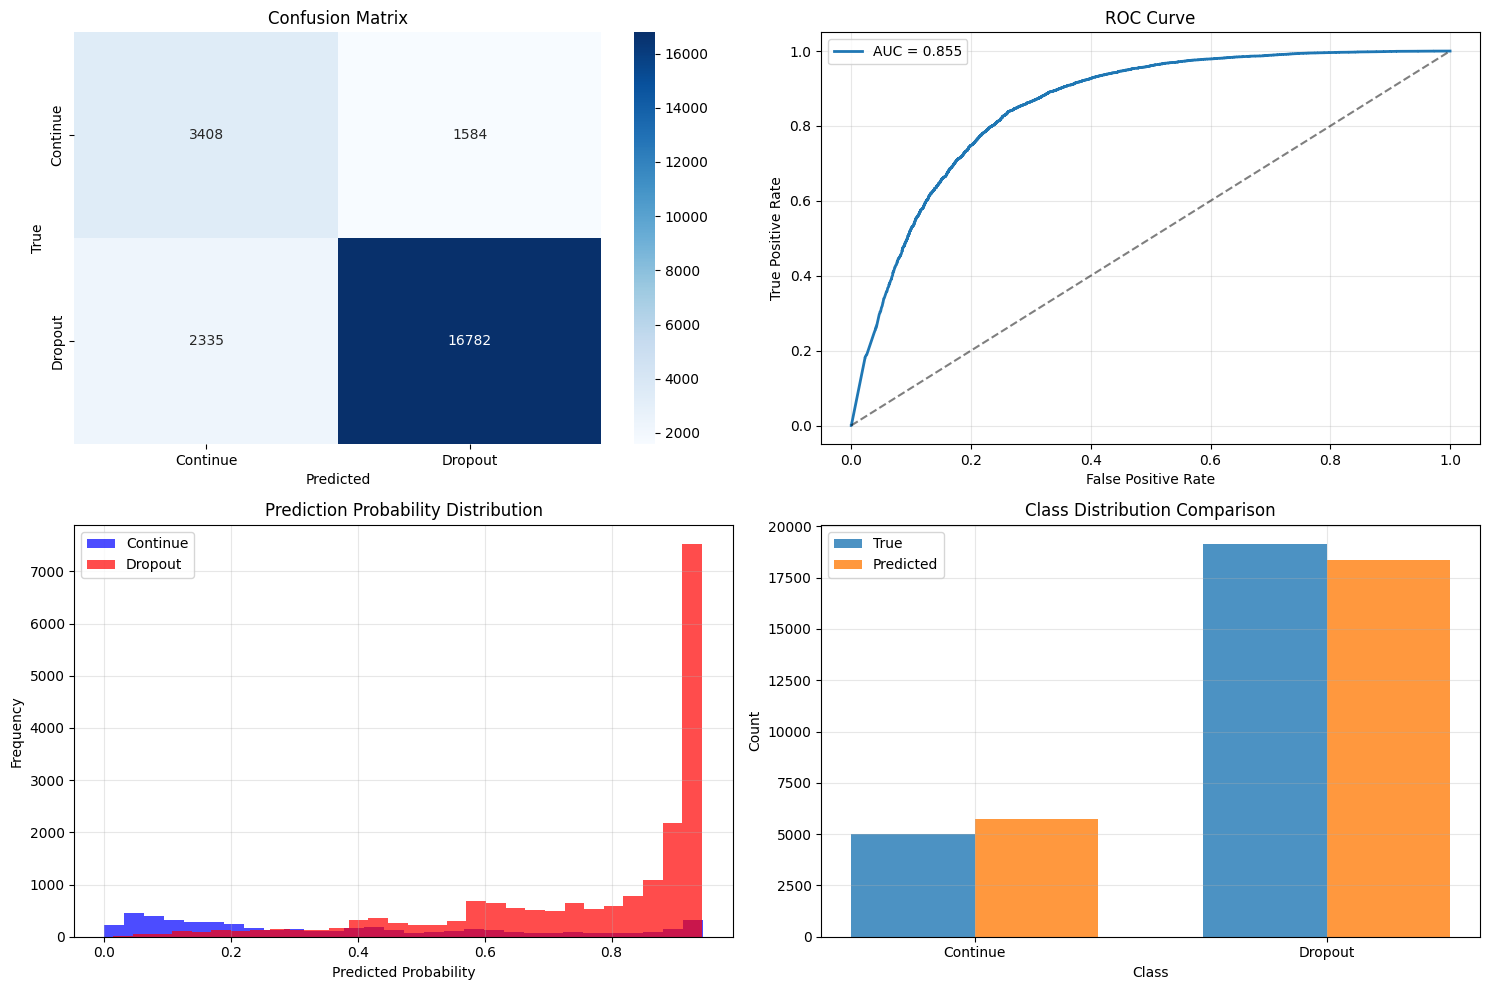


TRAINING COMPLETE!
Final Test Accuracy: 0.8374
Final Test F1-Score: 0.8954
Final Test AUC-ROC: 0.8553


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

class DropoutCNNModel:
    def __init__(self, input_shape=(30, 7, 1)):
        """
        Initialize the CNN model for Model 2 structure
        input_shape: (30 days, 7 events, 1 channel)
        """
        self.input_shape = input_shape
        self.model = None
        self.history = None
        self.events = ['access', 'problem', 'wiki', 'discussion', 'navigate', 'page_close', 'video']

    def build_model(self, learning_rate=0.001):
        """
        Build the CNN architecture optimized for 30x7 student activity matrices
        """
        model = models.Sequential([
            # Input layer - reshape to add channel dimension
            layers.Input(shape=self.input_shape),

            # First Convolutional Block
            # Use (3,3) kernels to capture temporal and event patterns
            layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1'),
            layers.BatchNormalization(name='bn1'),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1_2'),
            layers.MaxPooling2D((2, 2), name='pool1'),
            layers.Dropout(0.25, name='dropout1'),

            # Second Convolutional Block
            # Capture more complex patterns
            layers.Conv2D(64, (3, 2), activation='relu', padding='same', name='conv2'),
            layers.BatchNormalization(name='bn2'),
            layers.Conv2D(64, (3, 2), activation='relu', padding='same', name='conv2_2'),
            layers.MaxPooling2D((2, 2), name='pool2'),
            layers.Dropout(0.3, name='dropout2'),

            # Third Convolutional Block
            # Fine-grained pattern detection
            layers.Conv2D(128, (2, 2), activation='relu', padding='same', name='conv3'),
            layers.BatchNormalization(name='bn3'),
            layers.Dropout(0.35, name='dropout3'),

            # Global pooling to reduce overfitting
            layers.GlobalAveragePooling2D(name='global_pool'),

            # Dense layers for final classification
            layers.Dense(256, activation='relu', name='dense1'),
            layers.BatchNormalization(name='bn_dense1'),
            layers.Dropout(0.5, name='dropout_dense1'),

            layers.Dense(128, activation='relu', name='dense2'),
            layers.BatchNormalization(name='bn_dense2'),
            layers.Dropout(0.4, name='dropout_dense2'),

            layers.Dense(64, activation='relu', name='dense3'),
            layers.Dropout(0.3, name='dropout_dense3'),

            # Output layer
            layers.Dense(1, activation='sigmoid', name='output')
        ])

        # Compile model
        model.compile(
            optimizer=optimizers.Adam(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )

        self.model = model
        return model

    def prepare_data(self, X, y, test_size=0.2, random_state=42):
        """
        Prepare data for training
        """
        # Ensure X has the right shape (add channel dimension if needed)
        if len(X.shape) == 3:
            X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )

        print(f"Training set: {X_train.shape[0]} samples")
        print(f"Test set: {X_test.shape[0]} samples")
        print(f"Input shape: {X_train.shape[1:]}")

        # Calculate class weights
        unique, counts = np.unique(y_train, return_counts=True)
        total = len(y_train)
        class_weights = {}
        for i, count in enumerate(counts):
            class_weights[unique[i]] = total / (len(unique) * count)

        print(f"Class distribution - Training:")
        for label, count in zip(unique, counts):
            print(f"  Class {label}: {count} ({count/len(y_train)*100:.1f}%)")
        print(f"Class weights: {class_weights}")

        return X_train, X_test, y_train, y_test, class_weights

    def train(self, X_train, y_train, X_val=None, y_val=None,
              class_weights=None, epochs=100, batch_size=32,
              validation_split=0.2, patience=15):
        """
        Train the CNN model
        """
        if self.model is None:
            raise ValueError("Model not built. Call build_model() first.")

        # Setup callbacks
        callback_list = [
            callbacks.EarlyStopping(
                monitor='val_loss',
                patience=patience,
                restore_best_weights=True,
                verbose=1
            ),
            callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=max(patience//2, 5),
                min_lr=1e-7,
                verbose=1
            ),
            callbacks.ModelCheckpoint(
                'best_dropout_model.h5',
                monitor='val_loss',
                save_best_only=True,
                verbose=1
            )
        ]

        # Train model
        print("Starting training...")
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val) if X_val is not None and y_val is not None else None,
            validation_split=validation_split if X_val is None else 0,
            epochs=epochs,
            batch_size=batch_size,
            class_weight=class_weights,
            callbacks=callback_list,
            verbose=1
        )

        return self.history

    def evaluate(self, X_test, y_test, plot_results=True):
        """
        Evaluate the trained model
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")

        # Get predictions
        y_pred_proba = self.model.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
        y_pred_proba = y_pred_proba.flatten()

        # Calculate metrics
        test_loss, test_acc, test_prec, test_recall = self.model.evaluate(X_test, y_test, verbose=0)
        test_f1 = 2 * (test_prec * test_recall) / (test_prec + test_recall) if (test_prec + test_recall) > 0 else 0
        auc_score = roc_auc_score(y_test, y_pred_proba)

        print("\\n=== TEST SET EVALUATION ===")
        print(f"Accuracy: {test_acc:.4f}")
        print(f"Precision: {test_prec:.4f}")
        print(f"Recall: {test_recall:.4f}")
        print(f"F1-Score: {test_f1:.4f}")
        print(f"AUC-ROC: {auc_score:.4f}")

        # Classification report
        print("\\n=== CLASSIFICATION REPORT ===")
        print(classification_report(y_test, y_pred, target_names=['Continue', 'Dropout']))

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        print("\\n=== CONFUSION MATRIX ===")
        print(cm)

        if plot_results:
            self.plot_evaluation_results(y_test, y_pred, y_pred_proba, cm)

        return {
            'accuracy': test_acc,
            'precision': test_prec,
            'recall': test_recall,
            'f1_score': test_f1,
            'auc_roc': auc_score,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }

    def plot_training_history(self):
        """
        Plot training history
        """
        if self.history is None:
            print("No training history available.")
            return

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Accuracy
        axes[0, 0].plot(self.history.history['accuracy'], label='Training', linewidth=2)
        axes[0, 0].plot(self.history.history['val_accuracy'], label='Validation', linewidth=2)
        axes[0, 0].set_title('Model Accuracy', fontsize=14)
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Loss
        axes[0, 1].plot(self.history.history['loss'], label='Training', linewidth=2)
        axes[0, 1].plot(self.history.history['val_loss'], label='Validation', linewidth=2)
        axes[0, 1].set_title('Model Loss', fontsize=14)
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Precision
        axes[1, 0].plot(self.history.history['precision'], label='Training', linewidth=2)
        axes[1, 0].plot(self.history.history['val_precision'], label='Validation', linewidth=2)
        axes[1, 0].set_title('Model Precision', fontsize=14)
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # Recall
        axes[1, 1].plot(self.history.history['recall'], label='Training', linewidth=2)
        axes[1, 1].plot(self.history.history['val_recall'], label='Validation', linewidth=2)
        axes[1, 1].set_title('Model Recall', fontsize=14)
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plot_evaluation_results(self, y_true, y_pred, y_pred_proba, cm):
        """
        Plot evaluation results
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Confusion Matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Continue', 'Dropout'],
                   yticklabels=['Continue', 'Dropout'],
                   ax=axes[0, 0])
        axes[0, 0].set_title('Confusion Matrix')
        axes[0, 0].set_xlabel('Predicted')
        axes[0, 0].set_ylabel('True')

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        auc_score = roc_auc_score(y_true, y_pred_proba)
        axes[0, 1].plot(fpr, tpr, linewidth=2, label=f'AUC = {auc_score:.3f}')
        axes[0, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
        axes[0, 1].set_title('ROC Curve')
        axes[0, 1].set_xlabel('False Positive Rate')
        axes[0, 1].set_ylabel('True Positive Rate')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Prediction Distribution
        axes[1, 0].hist(y_pred_proba[y_true == 0], bins=30, alpha=0.7, label='Continue', color='blue')
        axes[1, 0].hist(y_pred_proba[y_true == 1], bins=30, alpha=0.7, label='Dropout', color='red')
        axes[1, 0].set_title('Prediction Probability Distribution')
        axes[1, 0].set_xlabel('Predicted Probability')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # Class Distribution
        unique, counts = np.unique(y_true, return_counts=True)
        pred_unique, pred_counts = np.unique(y_pred, return_counts=True)

        x = ['Continue', 'Dropout']
        true_counts = [counts[0], counts[1]] if len(counts) > 1 else [counts[0], 0]
        pred_counts_list = [pred_counts[0] if len(pred_counts) > 0 else 0,
                           pred_counts[1] if len(pred_counts) > 1 else 0]

        x_pos = np.arange(len(x))
        width = 0.35

        axes[1, 1].bar(x_pos - width/2, true_counts, width, label='True', alpha=0.8)
        axes[1, 1].bar(x_pos + width/2, pred_counts_list, width, label='Predicted', alpha=0.8)
        axes[1, 1].set_title('Class Distribution Comparison')
        axes[1, 1].set_xlabel('Class')
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].set_xticks(x_pos)
        axes[1, 1].set_xticklabels(x)
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def cross_validate(self, X, y, cv=5, epochs=50, batch_size=32):
        """
        Perform cross-validation
        """
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        cv_scores = []

        print(f"Performing {cv}-fold cross-validation...")

        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            print(f"\\nFold {fold + 1}/{cv}")

            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]

            # Build new model for this fold
            self.build_model()

            # Calculate class weights for this fold
            unique, counts = np.unique(y_train_fold, return_counts=True)
            total = len(y_train_fold)
            class_weights = {unique[i]: total / (len(unique) * counts[i]) for i in range(len(unique))}

            # Train
            history = self.model.fit(
                X_train_fold, y_train_fold,
                validation_data=(X_val_fold, y_val_fold),
                epochs=epochs,
                batch_size=batch_size,
                class_weight=class_weights,
                verbose=0,
                callbacks=[
                    callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
                ]
            )

            # Evaluate
            val_loss, val_acc, val_prec, val_recall = self.model.evaluate(X_val_fold, y_val_fold, verbose=0)
            cv_scores.append(val_acc)

            print(f"Validation Accuracy: {val_acc:.4f}")

        cv_scores = np.array(cv_scores)
        print(f"\\nCross-validation results:")
        print(f"Mean Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

        return cv_scores

# Usage example
def load_model2_data():
    """
    Load processed Model 2 data
    """
    try:
        print("Loading processed Model 2 data...")

        X = np.load('model2_X.npy')
        y = np.load('model2_y.npy')
        student_ids = np.load('model2_student_ids.npy')

        import json
        with open('model2_metadata.json', 'r') as f:
            metadata = json.load(f)

        print(f"Loaded data for {len(X)} students")
        print(f"Matrix shape: {X.shape}")
        print(f"Label distribution: {metadata['label_distribution']}")

        return X, y, student_ids, metadata

    except FileNotFoundError:
        print("Processed data files not found.")
        print("Please run the data transformer script first to process your CSV files.")
        return None, None, None, None

def main():
    """
    Main function demonstrating the complete workflow
    """
    print("=== Student Dropout Prediction with CNN (Model 2) ===")

    # Try to load processed data first
    X, y, student_ids, metadata = load_model2_data()

    if X is None:
        print("Using sample data for demonstration...")
        # For demonstration, create sample data with the correct structure
        n_samples = 1000
        X = np.random.randint(0, 5, size=(n_samples, 30, 7))  # Random activity counts
        y = np.random.binomial(1, 0.3, n_samples)  # 30% dropout rate
        print(f"Created sample data: {X.shape}")

    print(f"Working with {len(X)} students")
    print(f"Dropout rate: {np.mean(y)*100:.1f}%")

    # Initialize model
    cnn_model = DropoutCNNModel(input_shape=(30, 7, 1))

    # Build model
    model = cnn_model.build_model(learning_rate=0.001)
    print("\nModel built successfully!")
    model.summary()

    # Prepare data
    X_train, X_test, y_train, y_test, class_weights = cnn_model.prepare_data(X, y)

    # Train model
    print("\n" + "="*50)
    print("TRAINING PHASE")
    print("="*50)

    history = cnn_model.train(
        X_train, y_train,
        class_weights=class_weights,
        epochs=50,  # You can increase this for better results
        batch_size=32,
        patience=15
    )

    # Plot training history
    print("\nPlotting training history...")
    cnn_model.plot_training_history()

    # Evaluate model
    print("\n" + "="*50)
    print("EVALUATION PHASE")
    print("="*50)

    results = cnn_model.evaluate(X_test, y_test)

    # Optional: Cross-validation (uncomment if you want to run it)
    # print("\n" + "="*50)
    # print("CROSS-VALIDATION")
    # print("="*50)
    # cv_scores = cnn_model.cross_validate(X, y, cv=5, epochs=30)

    print("\n" + "="*50)
    print("TRAINING COMPLETE!")
    print("="*50)
    print(f"Final Test Accuracy: {results['accuracy']:.4f}")
    print(f"Final Test F1-Score: {results['f1_score']:.4f}")
    print(f"Final Test AUC-ROC: {results['auc_roc']:.4f}")

    return cnn_model, results

if __name__ == "__main__":
    model, results = main()
